## Part 3 - Markets and Ecoinvent
In this section I want to make the following points:
 - The use of Market processes dominates the construction of ecoinvent
 - Most markets are shallow (few suppliers, even fewer meaningfully distinct suppliers)
 - even apparently broad markets can have narrow observational / documentary basis
 
 

In [1]:
STUDY_PATH = '/data/GitHub/2018/variability_jlca/'
CATALOG = STUDY_PATH + 'catalog'

In [2]:
from antelope_catalog import LcCatalog
from lcatools import enum

In [3]:
cat = LcCatalog(CATALOG, quell_biogenic_CO2=True)

Loading JSON data from /data/GitHub/lca-tools/lcatools/qdb/data/flowable_synlist.json:
Loading JSON data from /data/GitHub/lca-tools/lcatools/qdb/data/quantity_synlist.json:
local.qdb: /data/GitHub/2018/variability_jlca/catalog/reference-quantities.json
Loading JSON data from /data/GitHub/2018/variability_jlca/catalog/reference-quantities.json:
local.qdb: /data/GitHub/lca-tools/lcatools/qdb/data/elcd_reference_quantities.json
25 new quantity entities added (25 total)
6 new flow entities added (6 total)


Specific questions we want to answer in a table:


------------- APOS ----- CUTOFF
- Total number of activities 

- Number of markets 

- Total number of exchanges 
- Number of exchanges provided by markets 
- Number of exchanges provided by nonmarkets 

- Number of nonmarket activities consumed by nonmarkets 



In [4]:
origins = ('local.ecoinvent.3.4.apos', 'local.ecoinvent.3.4.cutoff')

In [5]:
cat.show_interfaces()

local.ecoinvent.3.4.apos [basic, inventory]
local.ecoinvent.3.4.apos.index.20190118 [background, basic, index]
local.ecoinvent.3.4.conseq [basic, inventory]
local.ecoinvent.3.4.cutoff [basic, inventory]
local.ecoinvent.3.4.cutoff.index.20190118 [background, basic, index]
local.lcia.ecoinvent.3.1 [basic, index, quantity]
local.qdb [basic, index, quantity]


In [6]:
qc = cat.query(origins[1])

In [7]:
# total number of markets - cutoff
len([x for x in qc.processes(Name='^market')])

Loading JSON data from /data/GitHub/2018/variability_jlca/catalog/index/ffc0f70037f9e921067e85ac7e2d4ff0ba1bc3b5.json.gz:
local.ecoinvent.3.4.cutoff.index.20190118: /data/GitHub/2018/variability_jlca/catalog/index/ffc0f70037f9e921067e85ac7e2d4ff0ba1bc3b5.json.gz
local.ecoinvent.3.4.cutoff: /data/LCI/Ecoinvent/3.4/ecoinvent 3.4_cutoff_ecoSpold02
13459 new process entities added (13459 total)
19 new quantity entities added (19 total)
4881 new flow entities added (4881 total)


3966

In [8]:
# total number of markets - apos
len([x for x in cat.query(origins[0]).processes(Name='^market')])

Loading JSON data from /data/GitHub/2018/variability_jlca/catalog/index/a57075ecd68e35920696904ec830bc522fc6b2b2.json.gz:
local.ecoinvent.3.4.apos.index.20190118: /data/GitHub/2018/variability_jlca/catalog/index/a57075ecd68e35920696904ec830bc522fc6b2b2.json.gz
local.ecoinvent.3.4.apos: /data/LCI/Ecoinvent/3.4/ecoinvent 3.4_apos_ecoSpold02
13290 new process entities added (13290 total)
19 new quantity entities added (19 total)
4851 new flow entities added (4851 total)


3916

In [9]:
def _consumers_row(query, rf):
    count = len([x for x in query.consumers(rf.process.external_ref, rf.flow.external_ref)])
    return rf.process._name, rf.flow.external_ref, count


def do_row_count(origin):
    rowcount = []
    _q = cat.query(origin)
    for f in _q.foreground_flows():
        rowcount.append(_consumers_row(_q, f))

    for b in _q.background_flows():
        rowcount.append(_consumers_row(_q, b))
    
    print(origin)
    print('Total activities: %d' % len(rowcount))
    tot_exc = sum([k[2] for k in rowcount])
    print('\nTotal off-diagonal exchanges: %d' % tot_exc)
    bymkt = sum([k[2] for k in rowcount if k[0].startswith('market')])
    print('Exchanges satisfied by market: %d' % bymkt)
    print('Exchanges satisfied by supplier: %d' % (tot_exc - bymkt))
    print('Supplier fraction: %.5f' % ((tot_exc - bymkt) / tot_exc))
    return rowcount



In [10]:
rc_cutoff = do_row_count(origins[1])

local.ecoinvent.3.4.cutoff.index.20190118: /data/GitHub/2018/variability_jlca/catalog/archives/local.ecoinvent.3.4.cutoff.index.20190118_background.mat
Loading JSON data from /data/GitHub/2018/variability_jlca/catalog/archives/local.ecoinvent.3.4.cutoff.index.20190118_background.mat.index.json.gz:
local.ecoinvent.3.4.cutoff
Total activities: 14889

Total off-diagonal exchanges: 140342
Exchanges satisfied by market: 124375
Exchanges satisfied by supplier: 15967
Supplier fraction: 0.11377


In [11]:
rc_apos = do_row_count(origins[0])

local.ecoinvent.3.4.apos.index.20190118: /data/GitHub/2018/variability_jlca/catalog/archives/local.ecoinvent.3.4.apos.index.20190118_background.mat
Loading JSON data from /data/GitHub/2018/variability_jlca/catalog/archives/local.ecoinvent.3.4.apos.index.20190118_background.mat.index.json.gz:
local.ecoinvent.3.4.apos
Total activities: 14927

Total off-diagonal exchanges: 358524
Exchanges satisfied by market: 321811
Exchanges satisfied by supplier: 36713
Supplier fraction: 0.10240


- number of nonmarket activities consumed by nonmarkets

In [67]:
def nontrivial_producer(origin):
    query = cat.query(origin)
    count = list((0, 0, 0))
    for p in query.processes():
        if p['Name'].startswith('market'):
            continue
        for rx in p.references():
            cons = [t for t in p.consumers(rx.flow)]
            nmcons = [t for t in cons if not t.process['Name'].startswith('market')]
            if len(cons) > 1:
                count[0] += 1
                # print(rx)
                # print('%d consumers' % len(cons))
            if len(nmcons) > 0:
                count[1] += 1
                # print('%d nonmarket consumers' % len(nmcons))
            if len(cons) == len(nmcons):
                count[2] += 1
            yield len(cons), len(nmcons), rx
    print('%d multiconsumers;; %d nonmarket consumers;; %d un-marketed' % (count[0], count[1], count[2]))

def do_nm_count(origin):
    _nmc_ = [rx for rx in nontrivial_producer(origin)]
    _supp = sum([k[0] for k in _nmc_])
    _dir = sum([k[1] for k in _nmc_])
    _uma = sum([k[2] for k in _nmc_])
    print('Non-markets: %d' % len(_nmc_))
    print('Supplier consumption: %d' % _supp)
    print('Direct consumption: %d' % _dir)
    print('Activities not included in a market: %d' % _uma)
    return _nmc_
    

In [60]:
unmarketed = (k[2] for k in nm_cutoff if k[0] == k[1] != 0)

In [73]:
um = next(unmarketed)

In [74]:
str(um.process)

'[local.ecoinvent.3.4.cutoff] inert material landfill construction [CH]'

In [75]:
[str(x.process) for x in um.process.consumers()]

['[local.ecoinvent.3.4.cutoff] treatment of waste paperboard, inert material landfill [CH]',
 '[local.ecoinvent.3.4.cutoff] treatment of waste emulsion paint, inert material landfill [CH]',
 '[local.ecoinvent.3.4.cutoff] treatment of waste plastic plaster, inert material landfill [CH]',
 '[local.ecoinvent.3.4.cutoff] treatment of inert waste, inert material landfill [CH]',
 '[local.ecoinvent.3.4.cutoff] treatment of waste polyurethane, inert material landfill [CH]',
 '[local.ecoinvent.3.4.cutoff] treatment of waste gypsum, inert material landfill [CH]',
 '[local.ecoinvent.3.4.cutoff] treatment of scrap steel, inert material landfill [CH]',
 '[local.ecoinvent.3.4.cutoff] treatment of waste zeolite, inert material landfill [CH]',
 '[local.ecoinvent.3.4.cutoff] treatment of waste paint, inert material landfill [CH]',
 '[local.ecoinvent.3.4.cutoff] treatment of waste mineral wool, inert material landfill [CH]',
 '[local.ecoinvent.3.4.cutoff] treatment of waste glass, inert material landfil

In [13]:
nm_cutoff = do_nm_count(origins[1])

1804 multiconsumers;; 1838 nonmarket consumers
Non-markets: 10923
Supplier consumption: 15967
Direct consumption: 5692


In [14]:
nmc_apos = do_nm_count(origins[0])

1939 multiconsumers;; 1966 nonmarket consumers
Non-markets: 11011
Supplier consumption: 36713
Direct consumption: 26314


-------------- APOS ----- CUTOFF
- Number of markets 
- Number of singleton markets
- Number of shallow markets (dynamic range < 1%)
- Number of robust markets (N>2, dynamic range > 5%)

- Number of transport, freight, lorry
- number of market for transport, freight, lorry
- consumption of lorry processes hist / lolly




In [45]:
# let's try counting the market consumers directly
def count_market_inputs(origin):
    counts = []
    _q = cat.query(origin)
    for p in _q.processes(Name='^market'):
        ref = p.reference()
        dep = [k for k in p.inventory(ref) if k.termination is not None]
        supp = [k for k in dep if not _q.get(k.termination)['Name'].startswith('market')]
        slf = [k for k in dep if k.flow == ref.flow]
        
        counts.append((len(dep), len(supp), len(slf), p))
    print(origin)
    print('Markets: %d' % len(counts))
    print('Total Market inputs: %d' % sum([k[0] for k in counts]))
    print('Total Direct Supply exchanges: %d' % sum([k[1] for k in counts]))
    print('Total Same-ref exchanges: %d (includes market-to-market)' % sum([k[2] for k in counts]))
    return counts

In [46]:
ms_apos = count_market_inputs(origins[0])

local.ecoinvent.3.4.apos
Markets: 3916
Total Market inputs: 19338
Total Direct Supply exchanges: 10399
Total Same-ref exchanges: 11735 (includes market-to-market)


In [47]:
ms_cutoff = count_market_inputs(origins[1])

local.ecoinvent.3.4.cutoff: /data/LCI/Ecoinvent/3.4/ecoinvent 3.4_cutoff_ecoSpold02
local.ecoinvent.3.4.cutoff
Markets: 3966
Total Market inputs: 19388
Total Direct Supply exchanges: 10275
Total Same-ref exchanges: 11611 (includes market-to-market)


In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
from collections import Counter

In [34]:
[k[3]._name for k in ms_apos if k[2] == 0]

['market for steel removed by turning, primarily dressing, conventional [GLO]',
 'market for fava bean, feed, Swiss integrated production [GLO]',
 'market for land use change, annual crop [ES]',
 'market for land use change, annual crop [HU]',
 'market for transport, freight, lorry with refrigeration machine, 7.5-16 ton, EURO6, carbon dioxide, liquid refri(...)_15 [GLO]',
 'market for electrostatic paint [GLO]',
 'market for contouring, bronze [GLO]',
 'market for operation, internet access equipment [GLO]',
 'market for milking parlour [GLO]',
 'market for transport, freight, lorry with refrigeration machine, freezing [GLO]',
 'market for furnace, logs, hardwood storage area, 100kW [GLO]',
 'market for sawnwood, hardwood, raw, dried (u=10%) [RoW]',
 'market for indium rich leaching residues, from zinc production stockpiling [GLO]',
 'market for blower and heat exchange unit, Storkair G 90 [GLO]',
 'market for maintenance, train, passenger, long distance [GLO]',
 'market for acetanilid

In [76]:
mkt_depth_apos = sorted(z for z in Counter(k[2] for k in ms_apos).items())

In [77]:
mkt_depth_apos

[(1, 1076),
 (2, 2020),
 (3, 269),
 (4, 165),
 (5, 92),
 (6, 54),
 (7, 34),
 (8, 40),
 (9, 16),
 (10, 14),
 (11, 10),
 (12, 13),
 (13, 7),
 (14, 8),
 (15, 6),
 (16, 12),
 (17, 5),
 (18, 6),
 (19, 7),
 (20, 6),
 (21, 1),
 (22, 4),
 (23, 7),
 (24, 2),
 (25, 6),
 (26, 2),
 (27, 1),
 (29, 3),
 (30, 5),
 (32, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 3),
 (40, 3),
 (42, 2),
 (44, 1),
 (45, 1),
 (51, 1),
 (53, 1),
 (55, 2),
 (56, 2),
 (57, 1),
 (99, 1),
 (128, 1),
 (161, 1),
 (221, 1)]

<StemContainer object of 3 artists>

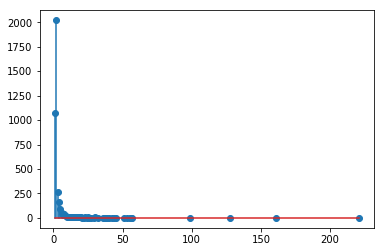

In [78]:
plt.stem(*zip(*mkt_depth_apos))

In [80]:
mkt_depth_c

[(1, 1096),
 (2, 2055),
 (3, 265),
 (4, 168),
 (5, 90),
 (6, 58),
 (7, 31),
 (8, 39),
 (9, 16),
 (10, 13),
 (11, 10),
 (12, 14),
 (13, 7),
 (14, 8),
 (15, 7),
 (16, 11),
 (17, 5),
 (18, 8),
 (19, 7),
 (20, 6),
 (21, 1),
 (22, 4),
 (23, 6),
 (24, 2),
 (25, 6),
 (26, 2),
 (27, 1),
 (29, 4),
 (30, 4),
 (32, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 3),
 (40, 3),
 (42, 2),
 (44, 1),
 (45, 1),
 (51, 1),
 (53, 1),
 (55, 2),
 (56, 1),
 (128, 1),
 (161, 1),
 (221, 1)]

<StemContainer object of 3 artists>

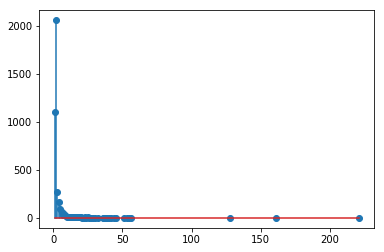

In [79]:
mkt_depth_c = sorted(z for z in Counter(k[2] for k in ms_cutoff).items())
plt.stem(*zip(*mkt_depth_c))

## Truck Transport: A narrow market model
Lorry Transport is something that's involved in every market process, which means it's involved in every "outward-facing" activity modeled by ecoinvent.  At first glance there appears to be a strong diversity of truck transport processes, but their breadth of empirical basis is extremely narrow and their usage within the database is highly limited.

We demonstrate this by looking at the usage of all truck transport / market for truck transport processes in the database, and finding out which ones actually get used to model freight transport.  To do this accurately, we ignore consumers whose products are the same as the consumption reference flows-- these are generally market processes that are creating averaged freight transport models.  Then we show which processes are used and how widely.

In [24]:
import pandas as pd
import numpy as np

In [25]:
def _t_f_l_gen(origin, thresh):
    _all_other = _ct_other = 0
    for p in cat.query(origin).processes(Name=('transport', 'freight', 'lorry')):
        rf = p.reference().flow
        cons = [x for x in p.consumers() if x.flow != rf]
        if len(cons) > thresh:
            yield len(cons), p._name
        else:
            _ct_other += 1
            _all_other += len(cons)
    yield _all_other, 'All other truck models (%d)' % _ct_other
    
def t_f_l_usage(origin, thresh=10):
    return pd.Series(*zip(*_t_f_l_gen(origin, thresh=thresh)), name=origin.split('.')[-1])

In [27]:
thresh = 4

l_apos = t_f_l_usage(origins[0], thresh=thresh)
l_cutoff = t_f_l_usage(origins[1], thresh=thresh)
lorry = pd.DataFrame(index=list(set(l_apos.index.values).union(set(l_cutoff.index.values))))
lorry['apos'] = l_apos
lorry['cutoff'] = l_cutoff

for k in lorry.columns:
    lorry.loc[lorry[k].isnull(), k] = 0
lorry.sort_values('apos', ascending=False).style.format({'apos': '{:.0f}', 'cutoff': '{:.0f}'})

,apos,cutoff
"market for transport, freight, lorry, unspecified [GLO]",1989,1840
"market for transport, freight, lorry 7.5-16 metric ton, EURO3 [GLO]",284,284
"market for transport, freight, lorry with reefer, cooling [GLO]",158,44
"market for transport, freight, lorry with refrigeration machine, cooling [GLO]",158,44
All other truck models (137),62,67
"market for transport, freight, lorry 16-32 metric ton, EURO4 [GLO]",34,12
"market for transport, freight, lorry >32 metric ton, EURO4 [GLO]",28,14
"transport, freight, lorry 16-32 metric ton, EURO5 [RER]",27,0
"market for transport, freight, lorry 16-32 metric ton, EURO5 [GLO]",27,31
"market for transport, freight, lorry 16-32 metric ton, EURO3 [GLO]",21,13


In [28]:
lorry.sum()

apos      2788.0
cutoff    2357.0
dtype: float64

In [29]:
(1989 + 284) / 2788

0.8152797704447633

In [81]:
(1840 + 284) / 2357

0.9011455239711498

In [83]:
m_t_f_l_u = next(cat.query('local.ecoinvent.3.4.apos').processes(Name='market for transport, freight, lorry, unspecified'))

In [88]:
_t_gen = (cat.query(m_t_f_l_u.origin).get(x.termination) for x in m_t_f_l_u.inventory() if x.termination is not None)

In [90]:
def _term_generator(_p_ref):
    for x in _p_ref.inventory():
        if x.termination is not None:
            yield cat.query(_p_ref.origin).get(x.termination)

In [91]:
_t_gen = _term_generator(m_t_f_l_u)

In [92]:
n = next(_t_gen)

In [101]:
n.show()

ProcessRef catalog reference (4f0da131-d826-45c4-b13b-04e4cab7e59a)
origin: local.ecoinvent.3.4.apos
UUID: 4f0da131-d826-45c4-b13b-04e4cab7e59a
   Name: market for transport, freight, lorry >32 metric ton, EURO6
Comment: no comment.
==Local Fields==
   SpatialScope: GLO
  TemporalScope: {'begin': '2009-01-01', 'end': '2017-12-31'}
Classifications: ['EcoSpold01Categories: transport systems/road', 'ISIC rev.4 ecoinvent: 4923:Freight transport by road']


In [93]:
enum(n.inventory())

 [00] Output: {*} [1 [metric ton*km]]     transport, freight, lorry >32 metric ton, EURO6 [CPC: 6511: Road transport services of freight]
 [01]  Input:     [ ---  [metric ton*km]] (#) transport, freight, lorry >32 metric ton, EURO6 [CPC: 6511: Road transport services of freight]
 [02]  Input:     [ ---  [metric ton*km]] (#) transport, freight, lorry >32 metric ton, EURO6 [CPC: 6511: Road transport services of freight]


In [94]:
_tt_gen = _term_generator(n)

In [95]:
nn = next(_tt_gen)

In [99]:
nn.show()
_ = enum(nn.inventory(nn.reference()))

ProcessRef catalog reference (6c71a30c-1e63-4a50-a4f0-679ce999f7b8)
origin: local.ecoinvent.3.4.apos
UUID: 6c71a30c-1e63-4a50-a4f0-679ce999f7b8
   Name: transport, freight, lorry >32 metric ton, EURO6
Comment: This dataset represents the service of 1tkm freight transport in a lorry of the size class >32 metric tons gross vehicle weight (GVW) and Euro VI emissions class. The transport datasets refer to the entire transport life cycle i.e. to the construction, operation, maintenance and end of life of vehicle and road infrastructures. Fuel consumption and emissions are for average European journeys and load factors and not representative of a specific transport scenario. The average load factors are taken from the Tremove model v2.7b (2009) and EcoTransIT (2011) report. These are as follows:

Lorry size class     Average load factor            GVW 

3.5-7.5t                             0.98t	                            4.98t 
7.5-16t                               3.29t                   

In [100]:
n0 = next(_tt_gen)
n0.show()
_ = enum(n0.inventory(n0.reference()))

ProcessRef catalog reference (205c0fb4-e23a-41df-b376-0550c22def35)
origin: local.ecoinvent.3.4.apos
UUID: 205c0fb4-e23a-41df-b376-0550c22def35
   Name: transport, freight, lorry >32 metric ton, EURO6
Comment: This dataset represents the service of 1tkm freight transport in a lorry of the size class >32 metric tons gross vehicle weight (GVW) and Euro VI emissions class. The transport datasets refer to the entire transport life cycle i.e. to the construction, operation, maintenance and end of life of vehicle and road infrastructures. Fuel consumption and emissions are for average European journeys and load factors and not representative of a specific transport scenario. The average load factors are taken from the Tremove model v2.7b (2009) and EcoTransIT (2011) report. These are as follows:

Lorry size class     Average load factor            GVW 

3.5-7.5t                             0.98t	                            4.98t 
7.5-16t                               3.29t                   

In [ ]:
# 0.0192 kg diesel per 1 tkm = 1.92 kg diesel per 100 tkm = about 2.5 L diesel per 100 tkm

In [85]:
enum(m_t_f_l_u.inventory())

 [00] Output: {*} [1 [metric ton*km]]     transport, freight, lorry, unspecified [CPC: 6511: Road transport services of freight]
 [01]  Input:     [ ---  [metric ton*km]] (#) transport, freight, lorry >32 metric ton, EURO6 [CPC: 6511: Road transport services of freight]
 [02]  Input:     [ ---  [metric ton*km]] (#) transport, freight, lorry 16-32 metric ton, EURO6 [By-product classification: allocatable product]
 [03]  Input:     [ ---  [metric ton*km]] (#) transport, freight, lorry 3.5-7.5 metric ton, EURO6 [CPC: 6511: Road transport services of freight]
 [04]  Input:     [ ---  [metric ton*km]] (#) transport, freight, lorry 7.5-16 metric ton, EURO6 [CPC: 6511: Road transport services of freight]
